In [2]:
import glob
from skimage import io, transform
from skimage import feature as sk_feature
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label as scipy_label
from moviepy.editor import VideoFileClip

%matplotlib inline

In [3]:
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = sk_feature.hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = sk_feature.hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
def bin_spatial(img, size=(32, 32)):                             
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
def featurize(img):
    assert(img.shape == (64, 64, 3))
    assert(img.dtype == np.uint8)
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (16, 16)
    hist_bins = (32)

    img = img.astype(np.float32) / 255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    assert(img.shape[2] == 3)
    hog1 = get_hog_features(img[:, :, 0], orient, pix_per_cell, cell_per_block, feature_vec=True)
    hog2 = get_hog_features(img[:, :, 1], orient, pix_per_cell, cell_per_block, feature_vec=True)
    hog3 = get_hog_features(img[:, :, 2], orient, pix_per_cell, cell_per_block, feature_vec=True)
    hog_features = np.hstack((hog1, hog2, hog3))
    
    spatial_features = bin_spatial(img, size=spatial_size)
    hist_features = color_hist(img, nbins=hist_bins)
    
    return np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)

In [5]:
def read_data(data_path='./data/vehicles'):
    feats = []
    for p in sorted(glob.glob('{}/*/*.png'.format(data_path))):
        feat = featurize(io.imread(p))
        feats.append(feat[0, :])
    return np.asarray(feats)

In [6]:
vehicles = read_data('./data/vehicles')
non_vehicles = read_data('./data/non-vehicles')

In [7]:
print(vehicles.shape)
print(non_vehicles.shape)
np.savez('./data/features.npz', vehicles=vehicles, non_vehicles=non_vehicles)

(8792, 6156)
(8968, 6156)


# Train

In [8]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

X = np.vstack((vehicles, non_vehicles)).astype(np.float64)                        
y = np.hstack((np.ones(len(vehicles)), np.zeros(len(non_vehicles))))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ppl = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

ppl.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(ppl.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9935


In [10]:
from sklearn.externals import joblib
joblib.dump(ppl, 'car_model.pkl')

['car_model.pkl']

# Test

In [11]:
def find_cars(img, ystart, ystop, scale, ppl, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    candidates = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_prediction = ppl.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                candidates.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img, candidates[-1][0], candidates[-1][1], (0,0,255), 6) 
                
    return candidates, draw_img


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def filter_candidates(img, candidates, heat_threshold=1):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # add heat
    for box in candidates:
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Apply threshold to help remove false positives
    heat[heat <= heat_threshold] = 0

    # Visualize the heatmap when displaying    
    heat = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = scipy_label(heat)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return labels, draw_img, heat


In [27]:
class CarDetector(object):
    
    def __init__(self):
        self.ppl = joblib.load('car_model.pkl') 
        self.ystart = 400
        self.ystop = 656
        self.scale = 1.5

        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.spatial_size = (16, 16)
        self.hist_bins = 32
        self.heat_threshold = 1
        
    def detect(self, img):
        assert(len(img.shape) == 3 and img.shape[2] == 3 and img.dtype == np.uint8)

        candidates = []
        for scale in (0.75, 1, 1.25, 1.5):
            c, _ = find_cars(img, self.ystart, self.ystop, scale, self.ppl, 
                             self.orient, self.pix_per_cell, self.cell_per_block, 
                             self.spatial_size, self.hist_bins)
            candidates.extend(c)
        labels, car_img, heat_img = filter_candidates(img, candidates, self.heat_threshold)
        return car_img, out_img, heat_img, labels

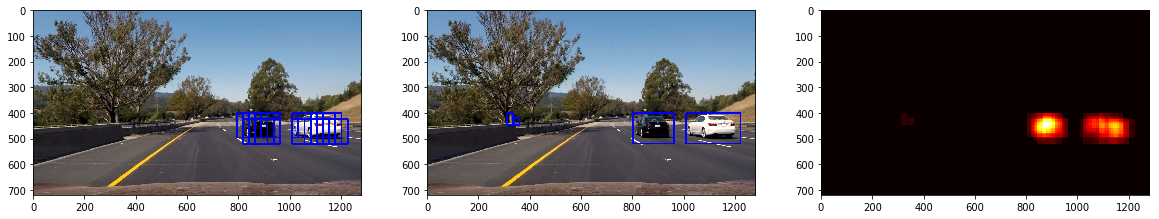

In [28]:
img = io.imread('test_images/test6.jpg')
car_img, out_img, heat_img, labels = CarDetector().detect(img)
# print(labels)

plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(out_img)
plt.subplot(132)
plt.imshow(car_img)
plt.subplot(133)
plt.imshow(heat_img, cmap='hot')
plt.show()

In [29]:
def detect_cars_video(inp_file, out_file):
    detector = CarDetector()
    out_clip = VideoFileClip(inp_file).fl_image(lambda frame: detector.detect(frame)[0])
    out_clip.write_videofile(out_file, audio=False, verbose=False)
    return out_clip

In [ ]:
detect_cars_video('project_video.mp4', 'project_video_detected.mp4')

 89%|████████▉ | 1127/1261 [58:27<06:59,  3.13s/it] 